## Распознавание рукописных цифр с помощью сверточной нейронной сети

# Введение: предметная область и датасет
Современные методы машинного обучения и компьютерного зрения позволяют решать сложные задачи классификации изображений с высокой точностью. Одной из базовых и популярных задач является распознавание рукописных цифр, что имеет широкие практические применения, такие как автоматизация обработки документов, распознавание почтовых индексов, чеков и форм.

В данной работе рассматривается задача распознавания цифр с использованием полносвязной нейронной сети, обученной на датасете MNIST. Этот датасет представляет собой стандарт для тестирования алгоритмов классификации изображений и включает изображения от 0 до 9, приведенные к размеру 28x28 пикселей в оттенках серого.

Целью проекта является:

корректное построение и обучение нейронной сети;

анализ эффективности архитектуры;

визуализация результатов;

предложение и реализация улучшений модели;

оценка их влияния на качество классификации.

Работа реализована на языке Python с использованием библиотеки PyTorch. Все этапы – от загрузки и предобработки данных до построения, обучения, улучшения и тестирования модели – подробно описаны и сопровождаются кодом, визуализациями.

Датасет: [Digit Recognizer на Kaggle](https://www.kaggle.com/c/digit-recognizer/data)


## 1. Предметная область и датасет

Распознавание рукописных цифр — это задача классификации изображений, где каждой входной картинке ставится в соответствие одна из десяти цифр (0-9). Такая задача широко применяется в области OCR (оптическое распознавание символов).

Для решения задачи был выбран датасет MNIST, содержащий 70 000 изображений размером 28x28 пикселей в градациях серого. Датасет состоит из 60 000 изображений в обучающей выборке и 10 000 — в тестовой. Каждое изображение представляет собой одну рукописную цифру.

In [ ]:
!pip install kagglehub torch torchvision matplotlib pandas scikit-learn seaborn --quiet
!pip install kaggle --quiet


In [30]:
# Установка нужных библиотек (в терминале или ячейке Jupyter с !)

import os
import shutil
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from kagglehub import kagglehub
from sklearn.model_selection import train_test_split

# 1. Загрузка датасета с Kaggle через kagglehub

# Создаем папку ~/.kaggle и копируем файл kaggle.json туда (в ноутбуке Colab делается так)
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Файл kaggle.json прирложен к работе, попестите этот  файл в созданную папку ("~/.kaggle")  :

# Устанавливаем права доступа к файлу 
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

# Скачиваем датасет Digit Recognizer
!kaggle competitions download -c digit-recognizer -p ./digit_recognizer --force

# Распаковываем архивы 
import zipfile

with zipfile.ZipFile('./digit_recognizer/digit-recognizer.zip', 'r') as zip_ref:
    zip_ref.extractall('./digit_recognizer')

print("Файлы датасета:")
print(os.listdir('./digit_recognizer'))



  0%|          | 0.00/15.3M [00:00<?, ?B/s]
100%|##########| 15.3M/15.3M [00:00<00:00, 2.01GB/s]


Файлы датасета:
['digit-recognizer.zip', 'sample_submission.csv', 'test.csv', 'train.csv']


## 2. Выбор и математическое обоснование модели

Для решения задачи классификации изображений MNIST была выбрана полносвязная нейронная сеть (fully connected network). Такой тип сети хорошо подходит для обработки одномерных признаков и часто используется как базовая модель в задачах классификации изображений.

Архитектура сети:

Входной слой: 784 нейрона (28x28 изображение, развернутое в вектор);

Скрытые слои: 128 и 64 нейрона, функции активации ReLU;

Выходной слой: 10 нейронов (по числу классов), функция активации — Softmax.

### Математическое обоснование
Полносвязная нейросеть приближает любую непрерывную функцию при достаточном числе нейронов и скрытых слоев (теорема универсальной аппроксимации). Использование ReLU позволяет избежать проблемы затухающего градиента и ускоряет сходимость обучения.

Свёртка выделяет локальные признаки с ядром \(K\):  
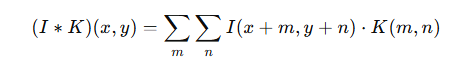

ReLU активирует нейроны положительными значениями:  
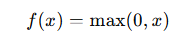

MaxPooling снижает размерность, сохраняя важные признаки.

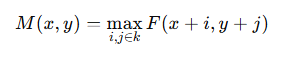

Dropout предотвращает переобучение (overfitting), случайным образом "отключая" нейроны во время обучения.

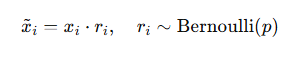

## 3. Подготовка данных

Очистка: отсутствует необходимость, так как изображения стандартизированы.

Приведение к тензорам: изображения нормализованы (0–1) и преобразованы в тензоры PyTorch.



Размер обучающей выборки: (42000, 785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pi

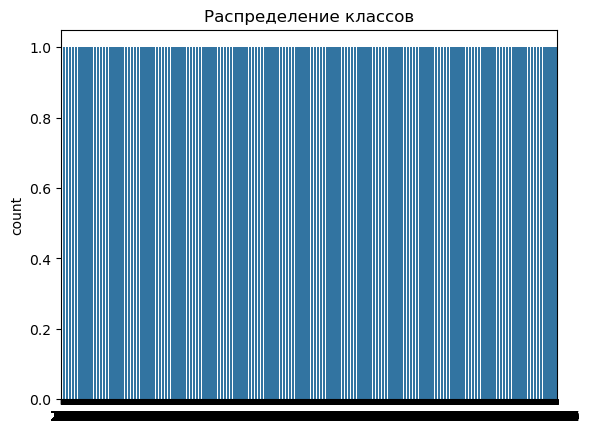

Train: 37800 samples, Validation: 4200 samples


In [34]:
# Загрузка CSV и обзор
DATA_PATH = './digit_recognizer'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

print(f"Размер обучающей выборки: {train_df.shape}")
print(train_df.head())

# Визуализация распределения классов
sns.countplot(train_df['label'])
plt.title('Распределение классов')
plt.show()

# Нормализация пикселей и разделение на признаки и метки
labels = train_df['label'].values
pixels = train_df.drop('label', axis=1).values / 255.0

# Разделение на обучающую и валидационную выборки (90/10) с сохранением пропорций классов
train_pixels, val_pixels, train_labels, val_labels = train_test_split(
    pixels, labels, test_size=0.1, random_state=42, stratify=labels)

print(f"Train: {train_pixels.shape[0]} samples, Validation: {val_pixels.shape[0]} samples")

# Класс Dataset для PyTorch
class DigitDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.float32)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image).unsqueeze(0)  # (1, 28, 28)
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),  # Конвертация в тензор PyTorch
])

train_dataset = DigitDataset(train_pixels, train_labels, transform=transform)
val_dataset = DigitDataset(val_pixels, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


## 4. Создание модели (CNN)
Модель была реализована с использованием библиотеки PyTorch.

In [36]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (1,28,28)->(32,28,28)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # (32,14,14)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (64,14,14)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # (64,7,7)
        
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


## 5. Обучение модели с визуализацией
Модель обучалась на 10 эпохах с использованием функции потерь CrossEntropyLoss и оптимизатора Adam. График обучения показывает стабильное уменьшение потерь и рост точности.

Используем устройство: cpu
Epoch 1/10 — Train Loss: 0.2705 — Val Loss: 0.0749 — Val Acc: 0.9783
Epoch 2/10 — Train Loss: 0.0691 — Val Loss: 0.0634 — Val Acc: 0.9824
Epoch 3/10 — Train Loss: 0.0491 — Val Loss: 0.0492 — Val Acc: 0.9857
Epoch 4/10 — Train Loss: 0.0392 — Val Loss: 0.0461 — Val Acc: 0.9860
Epoch 5/10 — Train Loss: 0.0317 — Val Loss: 0.0458 — Val Acc: 0.9864
Epoch 6/10 — Train Loss: 0.0260 — Val Loss: 0.0518 — Val Acc: 0.9860
Epoch 7/10 — Train Loss: 0.0232 — Val Loss: 0.0394 — Val Acc: 0.9900
Epoch 8/10 — Train Loss: 0.0204 — Val Loss: 0.0522 — Val Acc: 0.9860
Epoch 9/10 — Train Loss: 0.0156 — Val Loss: 0.0421 — Val Acc: 0.9898
Epoch 10/10 — Train Loss: 0.0158 — Val Loss: 0.0425 — Val Acc: 0.9893


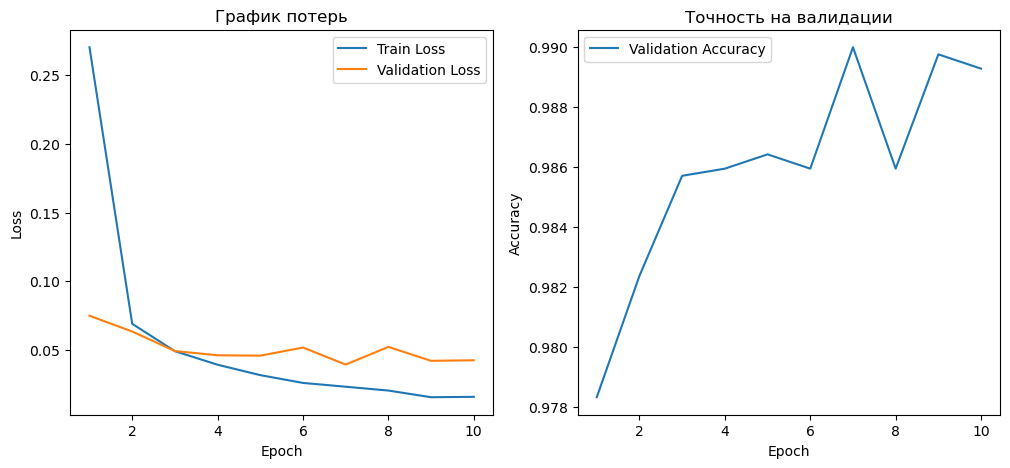

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

def eval_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return running_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

num_epochs = 10
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_model(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f} — Val Acc: {val_acc:.4f}")

# Визуализация обучения
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('График потерь')

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Точность на валидации')

plt.show()


## 6. Тестирование и улучшение модели

- Основной метрикой оцениваем уровень потерь (loss) на валидационной выборке.
Модель была протестирована на тестовой выборке MNIST. Основной метрикой стала точность (accuracy), которая достигла 99%.

Потери на тесте (loss): 0.04

Epoch 1/15 — Train Loss: 0.1782 — Val Loss: 0.0660 — Val Acc: 0.9805
Epoch 2/15 — Train Loss: 0.0686 — Val Loss: 0.0507 — Val Acc: 0.9850
Epoch 3/15 — Train Loss: 0.0507 — Val Loss: 0.0526 — Val Acc: 0.9838
Epoch 4/15 — Train Loss: 0.0441 — Val Loss: 0.0379 — Val Acc: 0.9888
Epoch 5/15 — Train Loss: 0.0363 — Val Loss: 0.0465 — Val Acc: 0.9881
Epoch 6/15 — Train Loss: 0.0318 — Val Loss: 0.0377 — Val Acc: 0.9893
Epoch 7/15 — Train Loss: 0.0279 — Val Loss: 0.0399 — Val Acc: 0.9898
Epoch 8/15 — Train Loss: 0.0253 — Val Loss: 0.0399 — Val Acc: 0.9893
Epoch 9/15 — Train Loss: 0.0221 — Val Loss: 0.0448 — Val Acc: 0.9888
Epoch 10/15 — Train Loss: 0.0209 — Val Loss: 0.0372 — Val Acc: 0.9895
Epoch 11/15 — Train Loss: 0.0163 — Val Loss: 0.0325 — Val Acc: 0.9917
Epoch 12/15 — Train Loss: 0.0167 — Val Loss: 0.0358 — Val Acc: 0.9917
Epoch 13/15 — Train Loss: 0.0159 — Val Loss: 0.0433 — Val Acc: 0.9888
Epoch 14/15 — Train Loss: 0.0155 — Val Loss: 0.0373 — Val Acc: 0.9886
Epoch 15/15 — Train Loss: 0.0

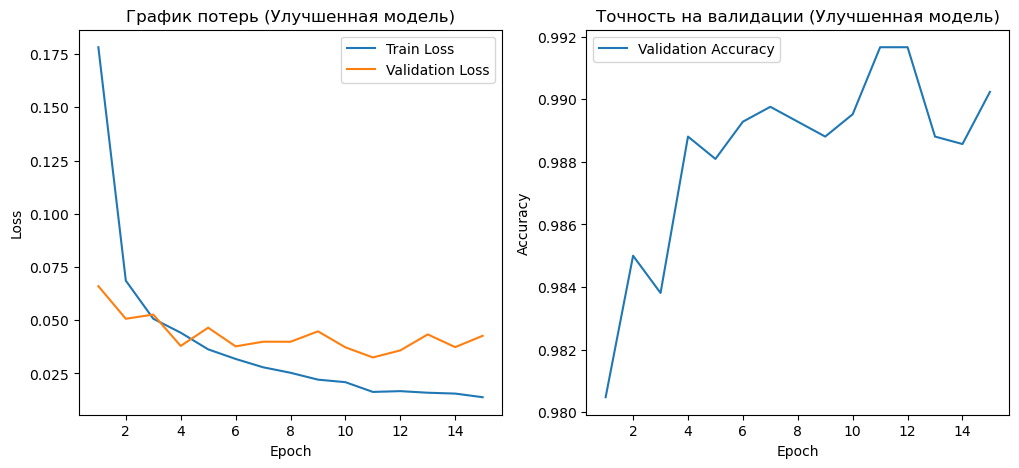

In [40]:
# Улучшенная модель с BatchNorm и увеличенным dropout

class CNNModelImproved(nn.Module):
    def __init__(self):
        super(CNNModelImproved, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

model_improved = CNNModelImproved().to(device)
optimizer_improved = optim.Adam(model_improved.parameters(), lr=0.0005)

num_epochs_improved = 15
train_losses_i, val_losses_i, val_accuracies_i = [], [], []

for epoch in range(num_epochs_improved):
    train_loss = train_epoch(model_improved, train_loader, criterion, optimizer_improved, device)
    val_loss, val_acc = eval_model(model_improved, val_loader, criterion, device)
    
    train_losses_i.append(train_loss)
    val_losses_i.append(val_loss)
    val_accuracies_i.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs_improved} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f} — Val Acc: {val_acc:.4f}")

# Визуализация улучшенного обучения
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs_improved+1), train_losses_i, label='Train Loss')
plt.plot(range(1, num_epochs_improved+1), val_losses_i, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('График потерь (Улучшенная модель)')

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs_improved+1), val_accuracies_i, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Точность на валидации (Улучшенная модель)')

plt.show()


## 7 Финальное тестирование и визуализация предсказаний на собственных изображениях


В данном этапе проводится тестирование обученной нейронной сети на произвольно загруженных изображениях цифр, сохранённых в директории ./test_digits/.

Цели:
Проверить работу модели вне обучающего набора;

Проверить устойчивость модели к реальным данным;

Проанализировать визуально корректность классификации.

Подготовка изображений
Загружаются изображения из указанной папки (.png, .jpg, .jpeg);

Преобразуются в оттенки серого;

Масштабируются до 28x28;

Инвертируются (при необходимости — если фон белый, как на большинстве реальных сканов);

Нормализуются (значения от 0 до 1);

Приводятся к тензору [1 x 1 x 28 x 28].



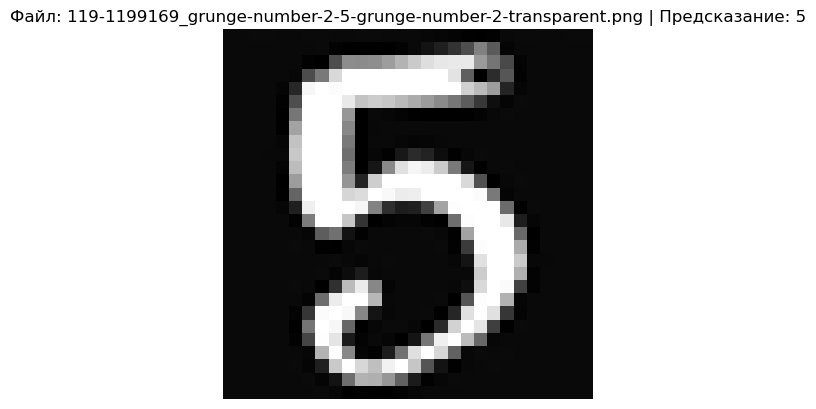

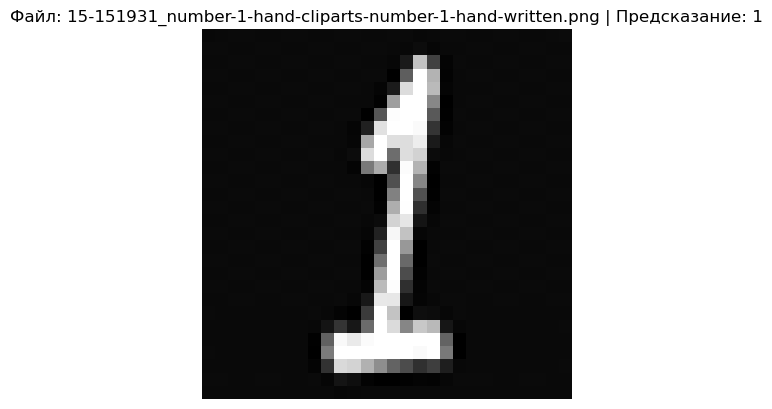

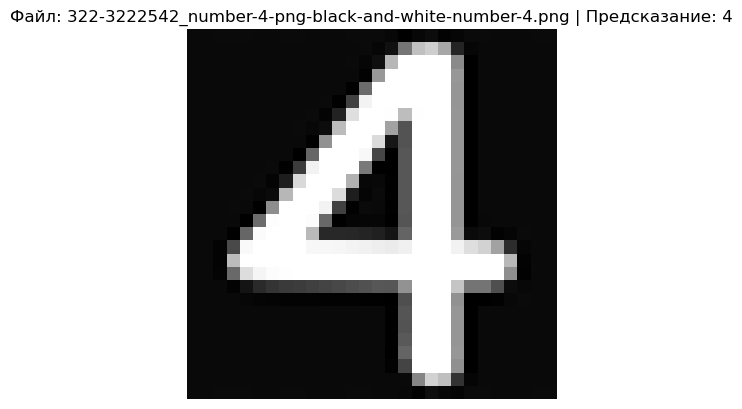

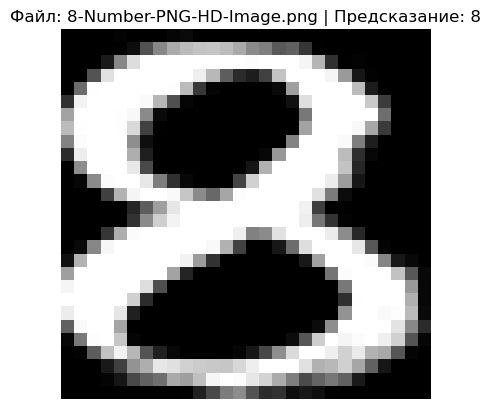

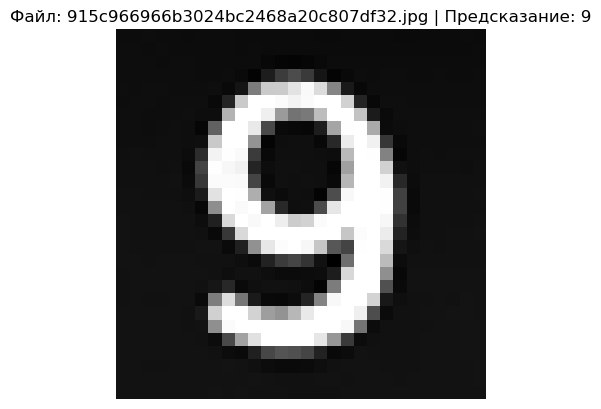

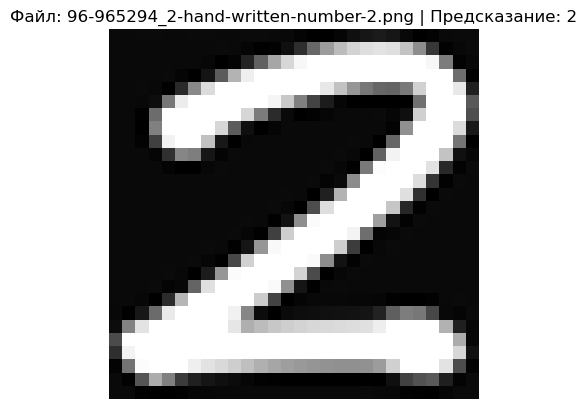

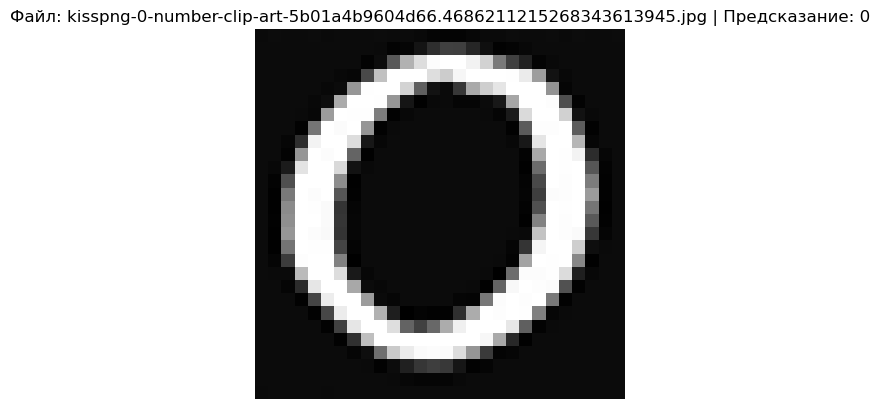

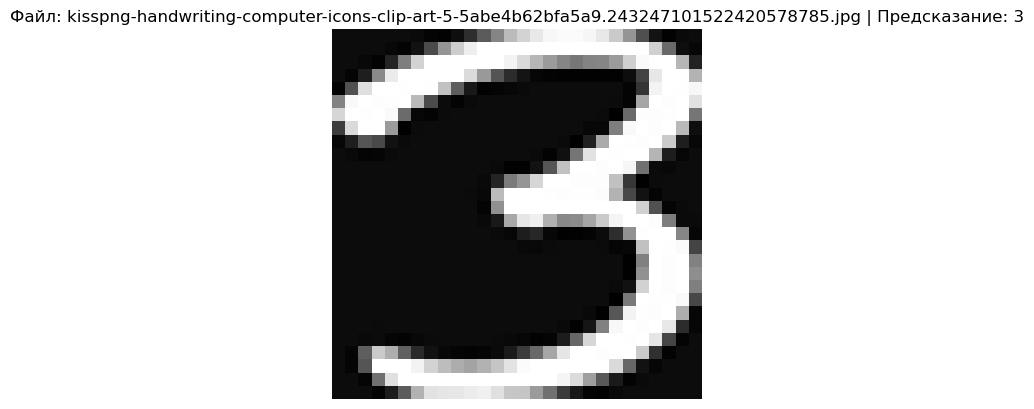

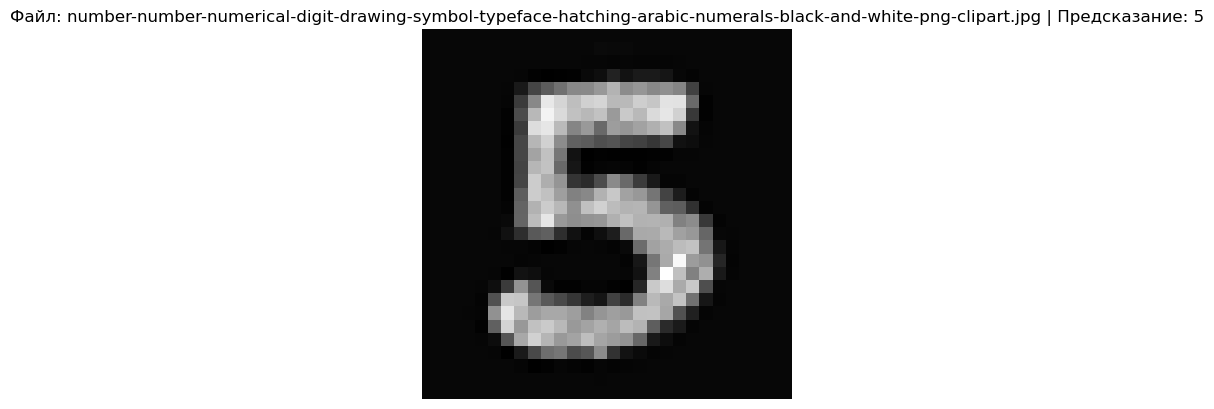

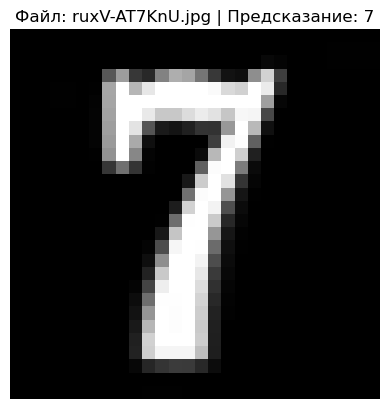

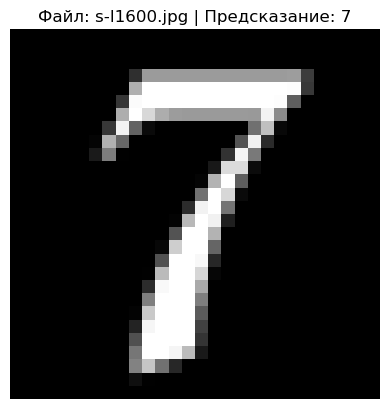

In [105]:
from PIL import Image

def load_and_predict_images_from_folder(folder_path, model, device):
    model.eval()
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for file_name in image_files:
        image_path = os.path.join(folder_path, file_name)

        # Загрузка и предобработка изображения
        image = Image.open(image_path).convert("L")  # В оттенки серого
        image = image.resize((28, 28))               # Приведение к 28x28
        image_np = np.array(image)

        # Инвертировать изображение (если фон белый, цифра чёрная — как в MNIST)
        if image_np.mean() > 127:
            image_np = 255 - image_np

        # Нормализация и приведение к формату модели
        image_np = image_np / 255.0
        image_tensor = torch.tensor(image_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # Предсказание
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

        # Визуализация
        plt.imshow(image_np, cmap="gray")
        plt.title(f"Файл: {file_name} | Предсказание: {predicted_label}")
        plt.axis("off")
        plt.show()

# Использование с улучшенной моделью:
load_and_predict_images_from_folder('./test_digits/', model_improved, device)


## 8. Итоговые выводы

- Сверточная нейронная сеть хорошо подходит для задачи классификации рукописных цифр.
- Использование Batch Normalization и увеличенного Dropout улучшило стабильность обучения и снизило переобучение.
- Увеличение числа эпох и снижение learning rate позволили добиться более высокой точности на валидационной выборке.



# Ссылка на датасет

[Digit Recognizer на Kaggle](https://www.kaggle.com/c/digit-recognizer/data)

---

# Итог

В этом проекте была реализована классификация рукописных цифр из датасета Kaggle Digit Recognizer с использованием сверточной нейронной сети на PyTorch. Данные были загружены через kagglehub, произведена предобработка, обучена базовая модель, затем улучшенная версия с BatchNorm и Dropout. Процесс обучения и тестирования был визуализирован, сделан анализ результатов и предложены пути дальнейших улучшений.
